<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep10-eda-submission-modeling?scriptVersionId=198995755" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (09/30/2024)
    * EDA 
    * Baseline modeling 1.0
    
    
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (58645, 12)
The dimension of the test dataset is: (39098, 11)
CPU times: user 165 ms, sys: 63.9 ms, total: 229 ms
Wall time: 353 ms


In [3]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / train.shape[0])

--- Train ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


--- Test ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


There are no missing values neither in the `train` nor `test` data frames. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the loan_status column, there are {sum(train.drop(columns=['loan_status']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the loan_status column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['loan_status'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `loan_status`.

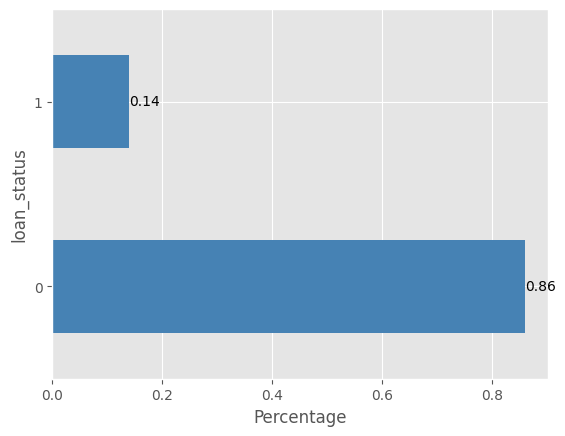

In [8]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `loan_status=1` is the less frequent label. Next, we explore the relationships between the input features and `loan_status`.

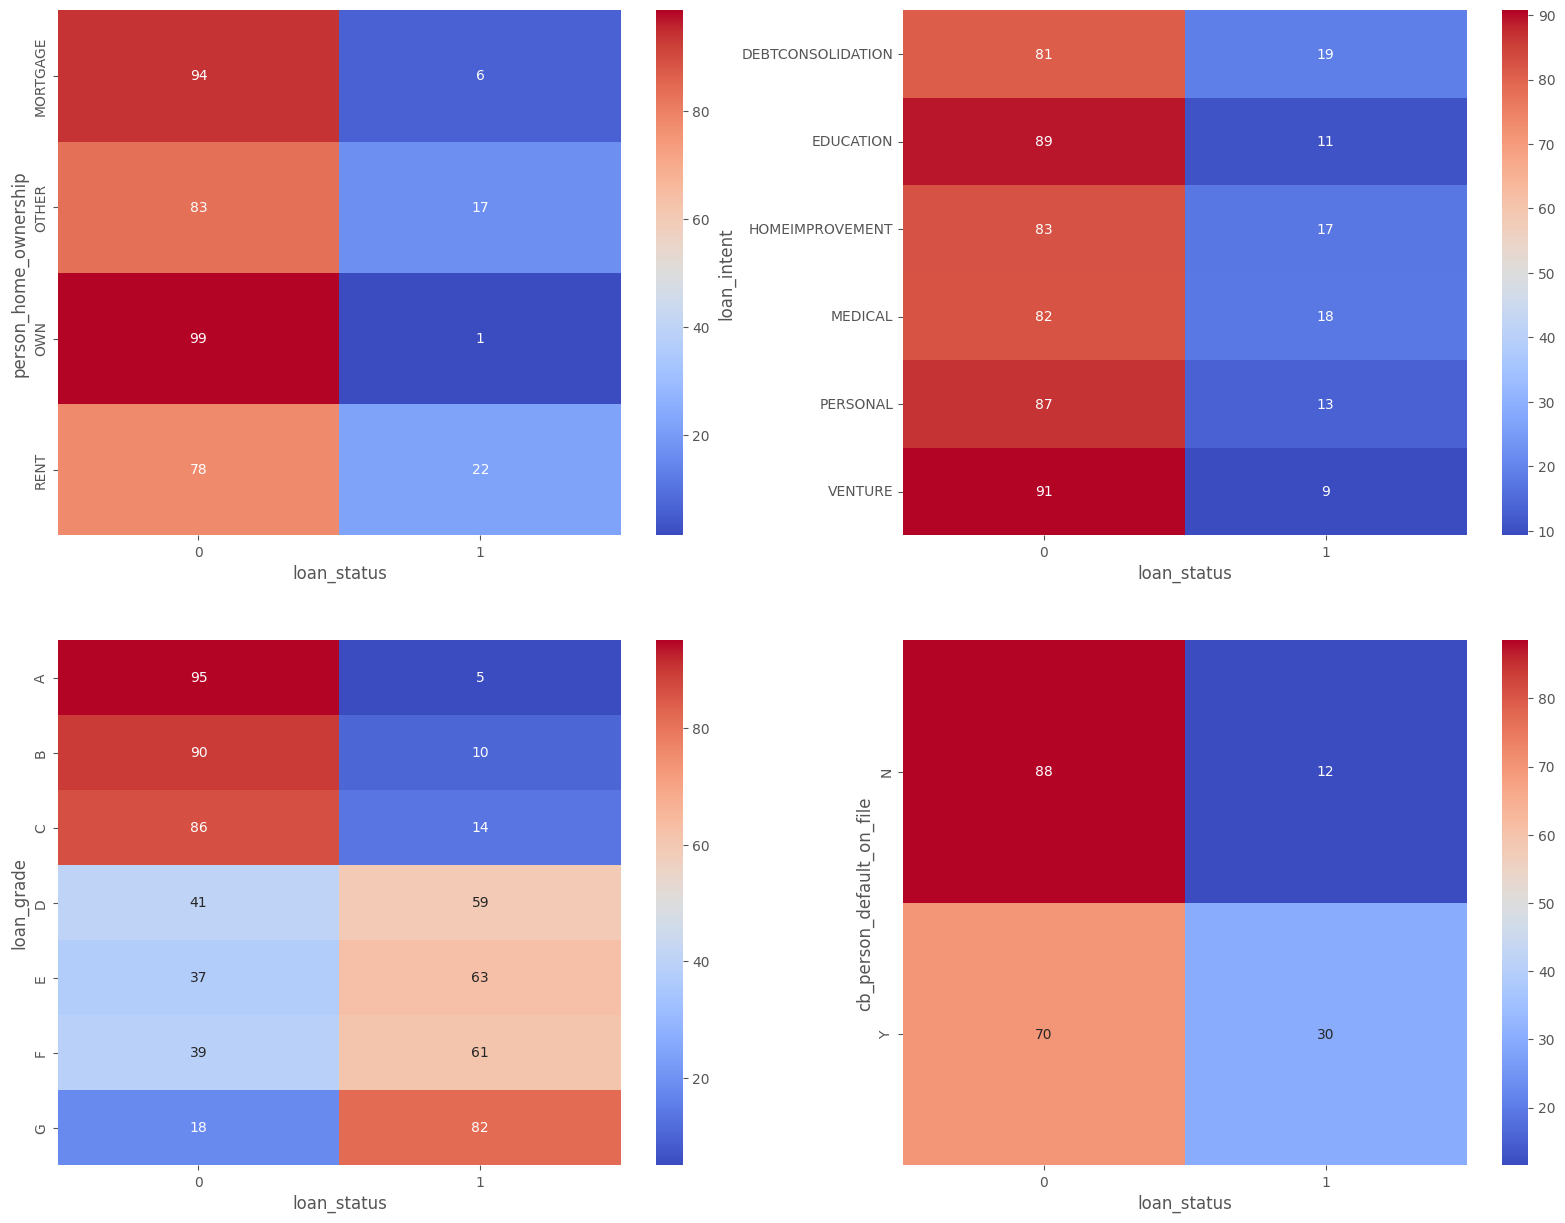

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['person_home_ownership'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 0])
sns.heatmap(data=round(100*pd.crosstab(train['loan_intent'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 1])
sns.heatmap(data=round(100*pd.crosstab(train['loan_grade'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 0]);
sns.heatmap(data=round(100*pd.crosstab(train['cb_person_default_on_file'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 1]);

These are a couple of observations from the above charts:

- When `loan_grade` is equal to `D, E, F,` and `G` have the higher proportions of `loan_status=1`
- `cb_person_default_on_file=Y` have a higher proportion `loan_status=1` when compared to `cb_person_default_on_file=N`

Next, let's explore the distribution of the numerical features and potential relationships with `loan_status`.

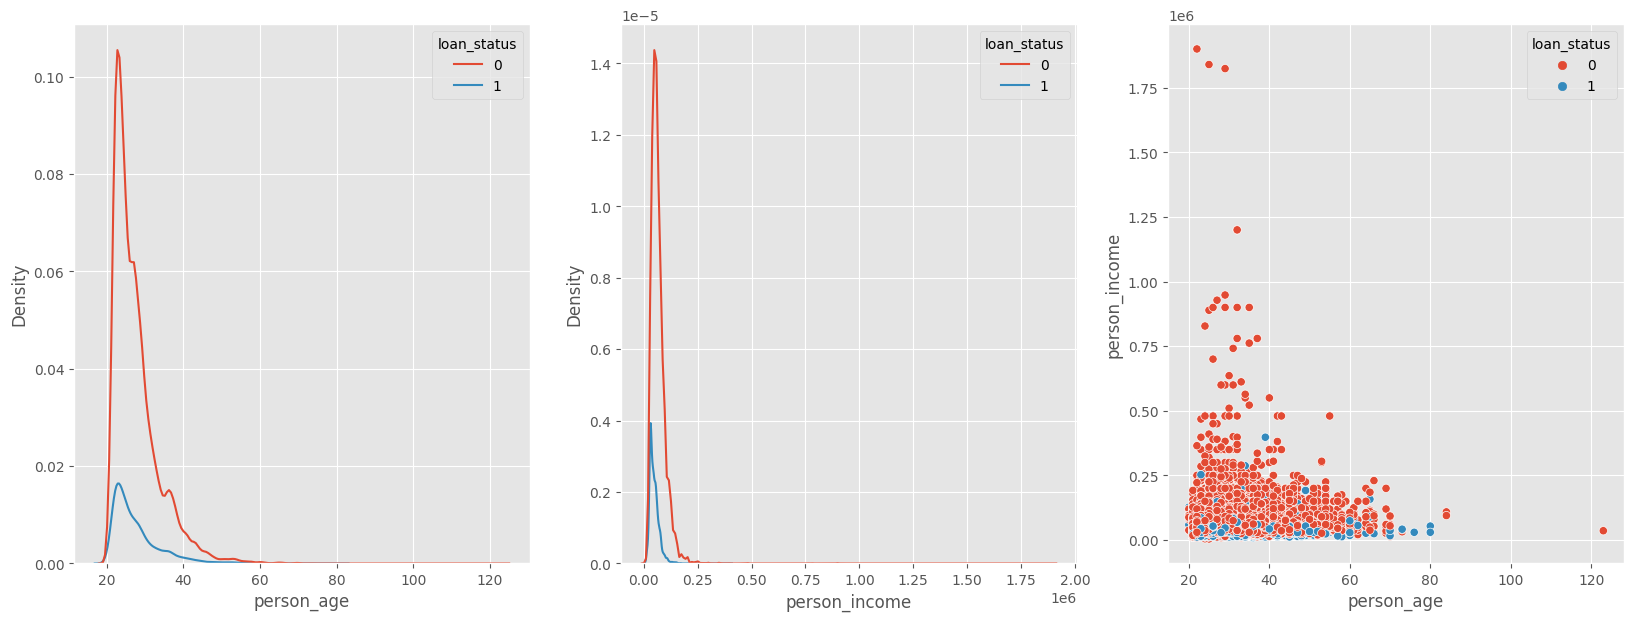

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_age', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='person_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_age', y='person_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_age` and `person_income`.
- There is one person with `person_age=123`.

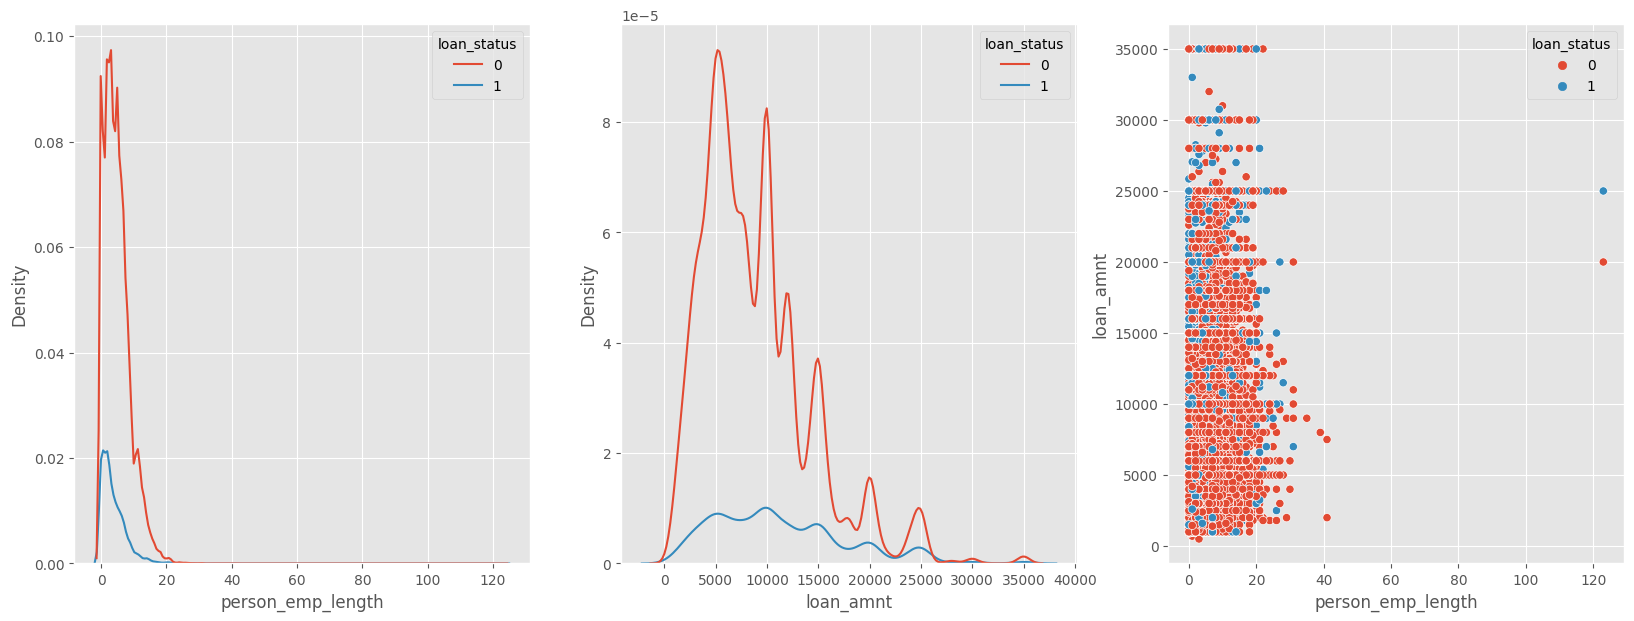

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_emp_length', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_amnt', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_emp_length', y='loan_amnt', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_emp_length` and `loan_amnt`.
- There are two persons with `person_emp_length=123`.

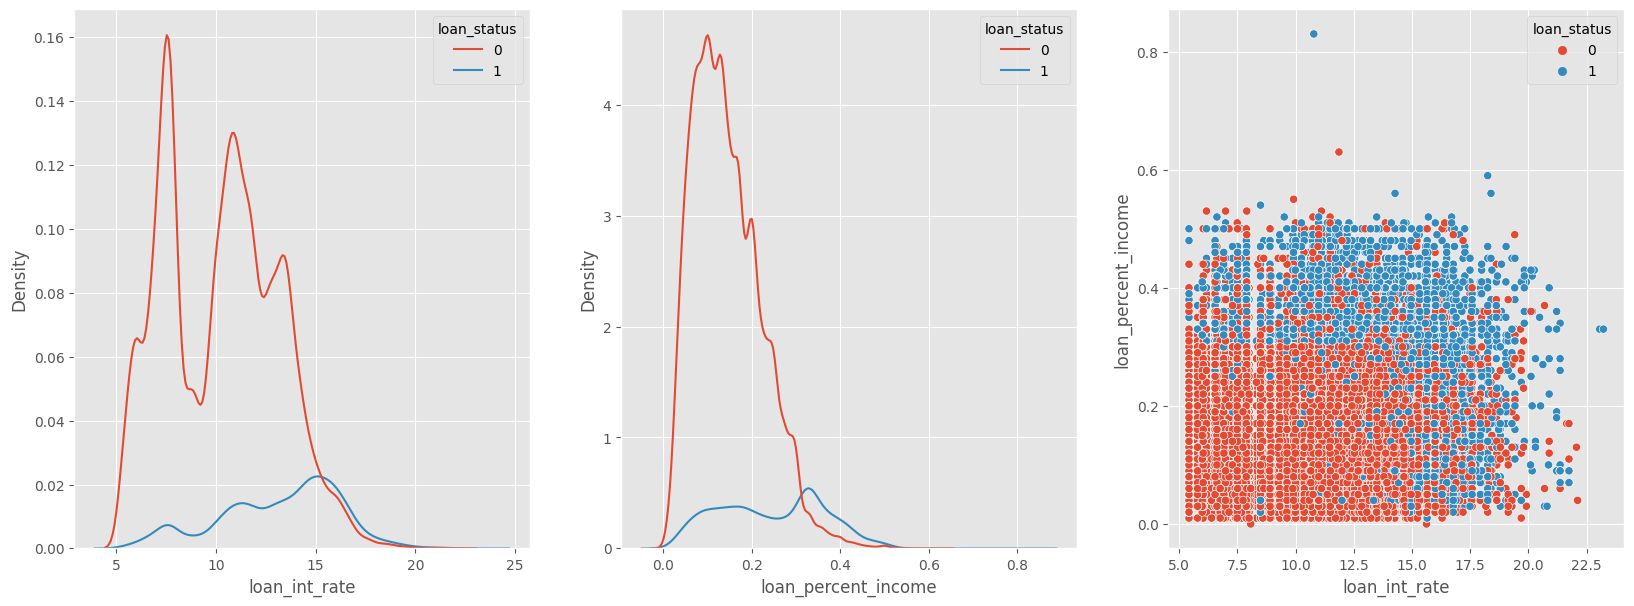

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='loan_int_rate', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_percent_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='loan_int_rate', y='loan_percent_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `loan_int_rate` and `loan_percent_income`.
- There are two loans with `loan_int_rate>23`.
- There are two loans with `loan_percent_income>0.6`.

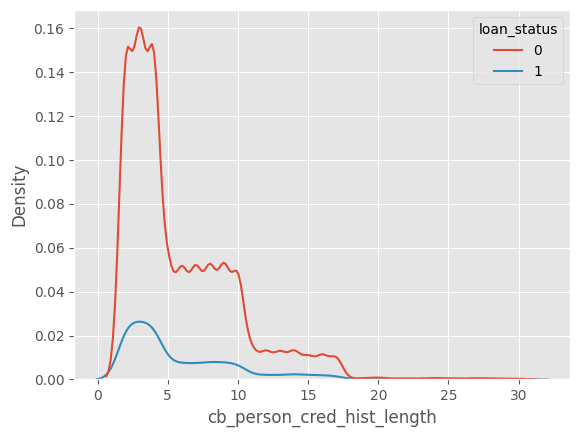

In [13]:
sns.kdeplot(data=train, x='cb_person_cred_hist_length', hue='loan_status');

From the above chart, we see that the distribution of `cb_person_cred_hist_length` is similar whether `loan_statu` is 0 or 1.

# Baseline Modeling 1.0

We first preprocess the data as follows.

In [14]:
%%time
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)


def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)

CPU times: user 58 ms, sys: 0 ns, total: 58 ms
Wall time: 57 ms


Then, we define the input and target feature for modeling purposes.

In [15]:
%%time
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 4.27 ms, sys: 134 µs, total: 4.41 ms
Wall time: 4.6 ms


Next, we train the `LightGBM` model as follows.

In [16]:
%%time
lgb_params = {'learning_rate': 0.1,
              'n_estimators': 100,
              'max_depth': 9,
              'reg_alpha': 0.02,
              'reg_lambda': 9,
              'num_leaves': 24,
              'colsample_bytree': 0.7,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9557976690753681
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9578858585016845
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9572295567909905
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.954475422911632
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9558726681825216
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9584293731090217
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9548027428936122
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9555382375039144
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9538147010810354
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9557605409582506
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9559606771008029
The 10-fold std oof ROC-AUC score of the LG

After that, we train the `XGBoost` model as follows.

In [17]:
%%time
xgb_params ={'n_estimators': 100,
             'max_depth': 9,
             'learning_rate': 0.1,
             'gamma': 2.6,
             'min_child_weight': 20,
             'colsample_bytree': 0.7,
             'enable_categorical': True,
             'n_jobs': -1}


scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9546660158807633
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9564148045856596
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9545200652373187
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9511701051177961
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.951161771883668
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9555866989425404
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9536965837662515
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9509503561975274
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9511808754731538
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9527979634288789
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9532145240513558
The 10-fold std oof ROC-AUC score of the

Next, we train the `CatBoost` model as follows.

In [18]:
cb_params = {'learning_rate': 0.1,
             'depth': 8,
             'bagging_temperature': 0.07,
             'l2_leaf_reg': 5,
             'grow_policy': 'Lossguide',
             'task_type': 'CPU'}

test_pool = Pool(data=test, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(loss_function='Logloss', iterations=100, **cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 0.9486331115105772
------------ Working on Fold 1 ------------
The oof RMSE score is 0.954408518946203
------------ Working on Fold 2 ------------
The oof RMSE score is 0.9534601969024179
------------ Working on Fold 3 ------------
The oof RMSE score is 0.9488003714241496
------------ Working on Fold 4 ------------
The oof RMSE score is 0.94450649397031
------------ Working on Fold 5 ------------
The oof RMSE score is 0.9516489391469596
------------ Working on Fold 6 ------------
The oof RMSE score is 0.9494662692908079
------------ Working on Fold 7 ------------
The oof RMSE score is 0.9469783042782997
------------ Working on Fold 8 ------------
The oof RMSE score is 0.9465740620568369
------------ Working on Fold 9 ------------
The oof RMSE score is 0.9420916766586136
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9486567944185174
The 10-fold std oof ROC-AUC score of the CatBoost model is 0.0019427249

Finally, we run an Optuna experiment to blend the out-of-fold predictions of `LightGBM`, `XGBoost`, and `CatBoost`.

In [19]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']

def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(3)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['xgb_preds'].values + 
                    weights[2]*x_test['cat_preds'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000, n_jobs=-1)

[I 2024-10-01 04:13:22,893] A new study created in memory with name: no-name-2c7c1592-b4fc-4ed4-89c0-a1f11da1e060
[I 2024-10-01 04:13:23,071] Trial 0 finished with value: 0.9547610720453955 and parameters: {'weight0': 0.908187522085322, 'weight1': 0.7669315197509099, 'weight2': 0.9689379964799707}. Best is trial 0 with value: 0.9547610720453955.
[I 2024-10-01 04:13:23,098] Trial 1 finished with value: 0.9557596744278358 and parameters: {'weight0': 0.8079841791264115, 'weight1': 0.5642160345835227, 'weight2': 0.005015111138614743}. Best is trial 1 with value: 0.9557596744278358.
[I 2024-10-01 04:13:23,113] Trial 2 finished with value: 0.9549416611188114 and parameters: {'weight0': 0.2437226337414384, 'weight1': 0.5053203999105463, 'weight2': 0.08015318087258896}. Best is trial 1 with value: 0.9557596744278358.
[I 2024-10-01 04:13:23,172] Trial 3 finished with value: 0.9549005925369054 and parameters: {'weight0': 0.7139431921375614, 'weight1': 0.837368168483707, 'weight2': 0.634341497277

CPU times: user 3min 35s, sys: 1.71 s, total: 3min 37s
Wall time: 3min 36s


In [20]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9560761307870027
  Params: 
    weight0: 0.8869839389968228
    weight1: 0.11525671974422026
    weight2: 7.190798178518829e-05
CPU times: user 668 µs, sys: 29 µs, total: 697 µs
Wall time: 435 µs


In [21]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['xgb_preds'] + w['weight2']*test['cat_preds'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna blender is 0.9560761307870027
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 110 ms


In [22]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds.head()

CPU times: user 18.4 ms, sys: 5.03 ms, total: 23.5 ms
Wall time: 23.2 ms


,lgb_preds,fold,xgb_preds,cat_preds
0,0.976622,0,0.967475,0.981435
1,0.017358,0,0.021466,0.021432
2,0.464042,0,0.546528,0.521027
3,0.014033,0,0.011269,0.017012
4,0.050428,0,0.126278,0.066193


In [23]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['xgb_preds'] + w['weight2']*temp['cat_preds'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 81.2 ms, sys: 22 µs, total: 81.2 ms
Wall time: 80.7 ms


In [24]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 13.3 ms, sys: 4.96 ms, total: 18.2 ms
Wall time: 27 ms


,id,loan_status
0,58645,0.973925
1,58646,0.019508
2,58647,0.517839
3,58648,0.013727
4,58649,0.074796


In [25]:
%time
submission.to_csv('baseline_sub_1.csv', index=False)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
